<a href="https://colab.research.google.com/github/Ferstuque/DeepLearning/blob/main/Face_detection_using_OpenCV_and_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for Human Face Detection with OpenCV and a ResNet Model

This notebook demonstrates a face detection and classification system using Computer Vision techniques. It leverages image manipulation and a pre-trained ResNet model to analyze images captured from a webcam. The goal is to enhance face detection accuracy and reliability by:

- Detecting faces: Identifying and locating faces within the webcam feed.
- Classifying faces: Determining the identity or category of detected faces.
- Confidence Scoring: Assigning a confidence score to each detection, filtering out low-confidence predictions and ensuring only reliable detections are considered.

Importing dependencies

In [1]:
import imutils
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from google.colab import files
from base64 import b64decode

Start the webcam using Java's built-in libraries

In [2]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

Click on *Capture*



In [3]:
image_file = take_photo()

<IPython.core.display.Javascript object>

Image preview


400 300


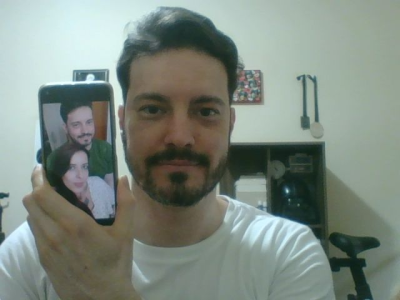

In [4]:
image = cv2.imread(image_file)

# Resize the image to a maximum width of 400 pixels.
image = imutils.resize(image, width=400)
(h, w) = image.shape[:2]
print(w,h)
cv2_imshow(image)

OpenCV's deep learning-based face detector utilizes the Single Shot Detector (SSD) architecture with a ResNet base network. The network is defined and trained using [Caffe Deep Learning framework](https://caffe.berkeleyvision.org/)

Downloading the pre-trained face detection models:

- Network definition (deploy.prototxt)
- Model weights (res10_300x300_ssd_iter_140000.caffemodel)

In [5]:
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt -qq
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel -qq

Loading the pre-trained face detection models




In [6]:
print("[INFO] loading model...")
prototxt = 'deploy.prototxt'
model = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, model)

[INFO] loading model...


Create an input blob using dnn.blobFromImage, resizing to (300x300) px and normalizing.

In [7]:
# Resize the image to a maximum width of 400 pixels.
image = imutils.resize(image, width=400)
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

In [8]:
print("[INFO] computing object detections...")
net.setInput(blob)
detections = net.forward()

[INFO] computing object detections...


Faça um loop para as detecções e desenhe caixas ao redor dos rostos detectados

Show the resulting image with confidence for 98%

In [9]:
for i in range(0, detections.shape[2]):

	# Extract the confidence score associated with the prediction
	confidence = detections[0, 0, i, 2]

	# Filter out weak detections by ensuring the 'confidence score' is above the minimum confidence threshold
	if confidence > 0.50: # Our detection here will only have a minimum confidence of 50%
		# Calculate the (x, y) coordinates of the bounding box
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")
		# Draw the bounding box around the face along with its associated probability
		text = "{:.2f}%".format(confidence * 100)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
		cv2.putText(image, text, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

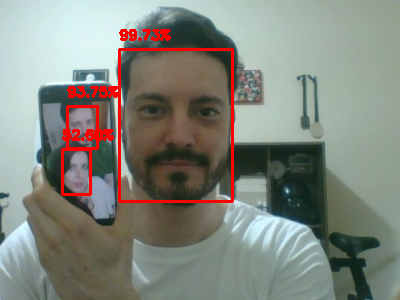

In [10]:
cv2_imshow(image)

In [11]:
image = cv2.imread(image_file)
image = imutils.resize(image, width=400)
(h, w) = image.shape[:2]
prototxt = 'deploy.prototxt'
model = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, model)
image = imutils.resize(image, width=400)
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
net.setInput(blob)
detections = net.forward()

400 300


Adding confidence > 98%

This filter improves face detection reliability by distinguishing between real and fake faces.

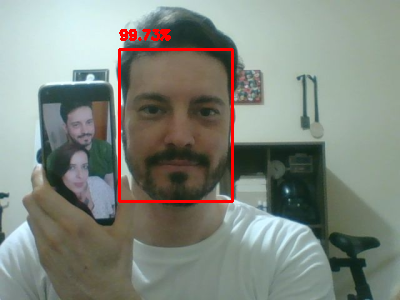

In [12]:
for i in range(0, detections.shape[2]):

	# Extract the confidence score associated with the prediction.
	confidence = detections[0, 0, i, 2]

	# Filter out weak detections by ensuring the 'confidence score' is above the minimum confidence threshold.
	if confidence > 0.98: # Our detection must have a minimum confidence of 99%
		# Calculate the (x, y) coordinates of the bounding box
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")
		# Draw the bounding box around the face along with its associated probability
		text = "{:.2f}%".format(confidence * 100)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
		cv2.putText(image, text, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

cv2_imshow(image)